In [617]:
import numpy as np

In [620]:
#适应度函数
def fitness_function_know(x):
    return np.sum(np.power(x-destination, 2))
    # if np.sqrt(np.sum(np.power(x-hurdle, 2))) < 30:
    #     l2 = -1/np.sum(np.power(x-destination, 2)) #+ 1/np.sum(np.power(x-hurdle, 2))
    #     # l2 = np.sum(np.power(x-destination, 2)) - 10*np.sum(np.power(x-hurdle, 2))
    # else:
    #     l2 = -1/np.sum(np.power(x-destination, 2))
    #     # l2 = np.sum(np.power(x-destination, 2))
    # return l2

def fitness_function_random(x):
    return -np.sum(5* np.power(x, 2) + np.power(x - 10 * np.random.rand(1, 2)[0], 2))

def fitness_function_destination(x):
    return np.sum(np.power(x-destination, 2))

## 一个例子要有的属性和方法：
##### 属性：空间维度、当前位置、历史轨迹、速度、自身历史最优点、评测函数、速度约束、位置约束
##### 方法：获得位置、修改位置、获得速度、修改速度、获得历史最优点、修改历史最优点、计算当前位置的评价

In [621]:
#单个粒子
class Particle:
    def __init__(self, v_init, dim, fitness_function):
        #初始化坐标、速度、最佳位置、适应度函数
        self.pos = np.array([0.0 for i in range(dim)])
        self.trajectory = [self.pos]
        self.v = v_init
        self.x_max = np.array([150, 150])
        self.x_min = np.array([0, 0])
        
        self.pbest = [0.0 for i in range(dim)]
        self.gbest = [0.0 for i in range(dim)]
        self.fitness_function = fitness_function
        self.bestfitness_value = float('Inf')
        self.gbestfitness_value = float('Inf')
        
        self.over_time =  0.1 #结束标准
        
        # 一个粒子所包含的三个状态
        self.over = 0 #0表示还未结束
        self.is_know = 0 #是否知道目标点
        self.is_single = 0 #是否是单个粒子搜索
    #知道目标
    def know(self):
        self.is_know = 1
    #判断是否是single，这个value在PSO中传入
    def single(self, value):
        self.is_single = value
    #当前位置
    def get_pos(self):
        return self.pos
    def set_pos(self, value):
        self.pos = value
        #不能太大
        max_sub = self.x_max - value
        for i, sub_x in enumerate(max_sub):
            if sub_x < 0:
                self.pos[i] = self.x_max[i]
        #也不能太小
        min_sub = self.x_min - value
        for i, sub_x in enumerate(min_sub):
            if sub_x > 0:
                self.pos[i] = self.x_min[i]
        self.trajectory.append(value)
    #历史路径
    def get_trajectory(self):
        return np.array(self.trajectory)
    #到达
    def is_over(self):
        if fitness_function_destination(self.get_pos()) < self.over_time and self.is_know:
            print(self.bestfitness_value, " ", self.over_time," ", self.pos)
            self.over = 1
    #粒子最优位置
    def get_pbest(self):
        return self.pbest
    def set_pbest(self, value):
        self.pbest = value
    #粒子群最优位置
    def get_gbest(self):
        return self.gbest
    def set_gbest(self, value):
        self.gbest = value
    #速度
    def get_v(self):
        return self.v
    def set_v(self, value):
        self.v = value
    #fitness
    def set_fitness_function(self, func):
        self.fitness_function = func
    def calc_fitness_value(self):
        return self.fitness_function(self.pos)
       
        # if self.is_know == 0:
        #     self.fitness_function = fitness_function_random
        #     return self.fitness_function(self.pos)
        # elif self.is_know == 1:
        #     self.fitness_function = fitness_function_know
        #     return self.fitness_function(self.pos)
    #pbest
    def get_bestfitness_value(self):
        return self.bestfitness_value
    def set_bestfitness_value(self, value):
        self.bestfitness_value = value
    #gbest
    def get_gbestfitness_value(self):
        return self.gbestfitness_value
    def set_gbestfitness_value(self, value):
        self.gbestfitness_value = value

PSO:
$$
v_{i+1} = \omega *v_i + c_1*rand_1*(pbest_i - x_i) + c_2*rand_2*(gbest_i - x_i)\\
x_i = x_i + v_{i+1}
$$

## PSO算法应包括：
##### 属性：w, c1, c2, 所有粒子, 所有例子最佳位置, 速度和位置约束， 迭代次数
##### 方法：更新每个粒子的速度，更新每个粒子的位置，判断是否已经到达终点，获得种群历史最优点以及评测、修改种群历史最优点以及评测 

In [745]:
#粒子群算法
class PSO:
    def __init__(self, dim, num, iter_num, v_max, destination, hurdle, fitness_function, best_fitness_value=float('Inf'), C1=1, C2=2, W=1):
        # 目标点和障碍物点
        self.destination = destination
        self.hurdle = hurdle
        # 三个超参数
        self.C1 = C1
        self.C2 = C2
        self.W = W

        self.dim = dim #粒子群的维度
        self.num = num #粒子群个数

        self.iter_num = iter_num #迭代次数
        
        self.v_max = v_max #速度最大值
        self.v_min = -v_max #反向最大速度
        
        self.fitness_function = fitness_function #评测函数
        self.bestfitness_value = best_fitness_value #种群历史最小评测，初始化为正无穷
        self.fitness_val_list = [] #每次迭代的最优值
        
        self.vs_init = self.init_v(dim, num)

        #构建一个距离判断表,如果距离在范围内就设为1，每次迭代后这个表都要更新
        self.team_relation = np.ones((num, num))

        #种群初始化
        self.Particle_team = [Particle(self.vs_init[i], self.dim, self.fitness_function) for i in range(num)]
    #速度初始化
    def init_v(self, dim, num):
        #这里只假设了dim=2的情况，其他情况需将rotate扩展
        PI = 3.1415626535
        angle = PI/2/(num -1)
        rotate = np.array([[np.cos(angle), -np.sin(angle)],
                           [np.sin(angle), np.cos(angle)]])
        vs = [np.array([0, 1])]
        for i in range(num-1):
            vs.append(np.matmul(vs[-1], rotate))
        vs = np.array(vs)
        return vs

    #计算两两点间的距离并判断是否在一个通信范围内
    def calc_distance(self, p1, p2):
        return np.sqrt(np.sum(np.power(p1-p2, 2)))

    def calc_relation(self):
        for i,p1 in enumerate(self.Particle_team):
            for j,p2 in enumerate(self.Particle_team):
                #距离小于一个值
                if self.calc_distance(p1.get_pos(), p2.get_pos()) < 50:
                    self.team_relation[i][j] = 1
                else:
                    self.team_relation[i][j] = 0
    
    #判断一个粒子是否是single的
    def calc_single(self, number):
        #关系矩阵对应行和为1，说明只有自身是1
        sum = np.sum(self.team_relation[number])
        if sum == 1:
            self.team_relation[number].single(1)
        else:
            self.team_relation[number].single(0)
    def get_gbestfitness_value_in_team(self, number):
        min_value = self.Particle_team[number].get_gbestfitness_value()

        for i, num in enumerate(self.team_relation[number]):
            #可以互相通信
            if num == 1:
                #fitness更小
                if self.Particle_team[i].get_gbestfitness_value() < min_value:
                    min_value = self.Particle_team[i].get_gbestfitness_value()
        return min_value
    #一次更新一个team的gbest和pos
    def update_gbestfitness_in_team(self, number, gbestfitness_value, gbest):
        for i, num in enumerate(self.team_relation[number]):
            #可以互相通信
            if num == 1:
                self.Particle_team[i].set_gbestfitness_value(gbestfitness_value)
                self.Particle_team[i].set_gbest(gbest)
    #如果一个粒子知道了目标和障碍，他会将信息传给相邻节点
    def trans_destination_hurdle(self, number):
        for i, num in enumerate(self.team_relation[number]):
            if num == 1:
                self.Particle_team[i].is_know = 1
    #更新一个团体的gbest
    def update_gbest_in_team(self, number):
        gbset_in_team = []
        gfitness_value_in_team = []
        for i, num in enumerate(self.team_relation[number]):
            particle = self.Particle_team[i]    
            if num == 1:
                gbset_in_team.append(particle.get_gbest())
                gfitness_value_in_team.append(particle.get_gbestfitness_value())
        #找到最小fitness对应的坐标
        best_index = np.argmin(np.array(gfitness_value_in_team))
        #更新所有gbest为know标准下的best
        for i, num in enumerate(self.team_relation[number]):
            particle = self.Particle_team[i]
            if num == 1:
                particle.set_gbestfitness_value(gfitness_value_in_team[best_index])
                particle.set_gbest(gbset_in_team[best_index])

    #由unknow变为know时需要对fitness_func进行转变，并重新计算fitness
    def fitness_value_init(self, number):
        for i, num in enumerate(self.team_relation[number]):
            particle = self.Particle_team[i]
            #可以互相通信并且之前没有初始化过
            if num == 1 and particle.is_know == 0:
                #将fitness函数更改为know的，并对自己的pbest进行更新
                particle.set_fitness_function(fitness_function_know)
                val = particle.calc_fitness_value()
                
                particle.set_bestfitness_value(val)
                particle.set_pbest(particle.get_pos())
                
                particle.set_gbestfitness_value(val)
                particle.set_gbest(particle.get_pos())
        #更新一个team中的gbest
        self.update_gbest_in_team(number)

    #获得种群中的每一个点
    def get_particle_team(self):
        return self.Particle_team

    #更新速度
    def update_v(self, part):
        if part.is_single:
            v = (self.W * part.get_v() + (self.C1 * np.random.rand() * (part.get_pbest() - part.get_pos()))).squeeze() + np.random.rand(1, 2)[0]*0.1
        else:
            v = (self.W * part.get_v() +  self.C1 * np.random.rand() * (part.get_pbest() - part.get_pos()) +\
                self.C2 * np.random.rand() * (part.get_gbest() - part.get_pos())).squeeze() + np.random.rand(1, 2)[0]*0.1
        
        if np.sqrt(np.sum(np.power(part.get_pos()-destination, 2))) < 50:
            v += (destination - part.get_pos())
        #如果在障碍附近，就绕着走
        for i in range(hurdle_num):
            if np.sqrt(np.sum(np.power(part.get_pos()-hurdle[i], 2))) < 15 and (part.get_pos()[1] < hurdle[i][1]):
                v -= v #归零
                PI = 3.1415626535
                angle = PI/2
                rotate = np.array([[np.cos(angle), -np.sin(angle)],
                                    [np.sin(angle), np.cos(angle)]])
                v += np.matmul((hurdle[i] - part.get_pos()), rotate)*0.1 + (part.get_pos()-hurdle[i])*0.0001
            #如果马上要碰到了
            if np.sqrt(np.sum(np.power(part.get_pos()-hurdle[i], 2))) < 8:
                v += part.get_pos() - hurdle[i]
            #如果已经距离目标点十分近了，就直接去就行
            if np.sqrt(np.sum(np.power(part.get_pos()-hurdle[i], 2))) < 15 and (part.get_pos()[1] < hurdle[i][1]) and \
                np.sqrt(np.sum(np.power(part.get_pos()-destination, 2))) < 10:
                v = (destination - part.get_pos())
        
        #不能太大
        max_sub = self.v_max - v
        for i, sub_v in enumerate(max_sub):
            if sub_v < 0:
                v[i] = self.v_max[i]
        #也不能太小
        min_sub = self.v_min - v
        for i, sub_v in enumerate(min_sub):
            if sub_v > 0:
                v[i] = self.v_min[i]
        if -0.1 < v[0] - v[1] < 0.1:
            v[0] = v[0] * 1.1
        #更新该粒子速度
        part.set_v(v)
    #更新位置、gbest、pbest、gfitness、pfitness、判断是否由unknow变为know，判断是否由single变为unsingle、判断是否结束条件
    def update_pos(self, part, number):
        #更新位置
        part.set_pos(part.get_pos() + part.get_v())
        #更新位置表
        self.calc_relation()
        #判断是否更新该粒子的历史最优点, 评测函数越小说明越接近目标，由unknow变为know
        if self.calc_distance(part.get_pos(), self.destination) < 50:
            #将这个信息传递给组中
            self.fitness_value_init(number)
            self.trans_destination_hurdle(number)
            
        val = part.calc_fitness_value()
        
        #如果粒子是单个粒子漫游,只更新自己的best即可
        if part.single(number) == 1:
            if val < part.get_bestfitness_value():
                #更新最佳评测函数
                part.set_bestfitness_value(val)
                #更新粒子最佳历史点
                part.set_pbest(part.get_pos())
        else:
            if val < part.get_bestfitness_value():
                #更新最佳评测函数
                part.set_bestfitness_value(val)
                #更新粒子最佳历史点
                part.set_pbest(part.get_pos())
            if val < self.get_gbestfitness_value_in_team(number):
                #更新群体最佳评测
                #更新种群历史最佳点
                self.update_gbestfitness_in_team(number, val, part.get_pos())
        #判断是否不需要进一步更新
        if val < part.over_time and part.is_know:
            part.is_over()
    def update(self):
        first = 1
        fast_trajectory = []
        for iter in range(self.iter_num):
            for number, part in enumerate(self.Particle_team):
                if not part.over:
                    self.update_v(part)
                    self.update_pos(part, number)
                else:
                    part.set_pos(part.get_pos())
                    if first:
                        fast_trajectory = part.get_trajectory()
            #记录一下最佳fitness，看是否收敛
            self.fitness_val_list.append(self.get_gbestfitness_value_in_team(1))
        return self.fitness_val_list, fast_trajectory

In [777]:
destination = np.array([130, 130])
hurdle_num = 10
hurdle = np.random.rand(hurdle_num, 2) * 150
hurdle = np.concatenate((hurdle, np.array([[110, 110]])), axis=0)
hurdle_num += 1

In [778]:
f = PSO(2, 10, 800, np.array([2,2]), destination, hurdle, fitness_function_random)

In [779]:
list, fast_trajectory = f.update()

0.09498888344360469   0.1   [130.20044082 130.2341204 ]
0.026209362225796843   0.1   [129.84077261 130.02925747]
0.08645035670450149   0.1   [130.29141277 129.96089815]
0.06253046598600077   0.1   [129.84604694 129.80294944]
0.054704140772489356   0.1   [129.9120216  130.21671166]
0.03286300865827327   0.1   [130.10997761 129.85588916]
0.07612966623500046   0.1   [130.08386358 129.73713774]
0.04184997685060236   0.1   [130.18952788 130.07700103]
0.0731282371124452   0.1   [130.24949444 129.89568911]


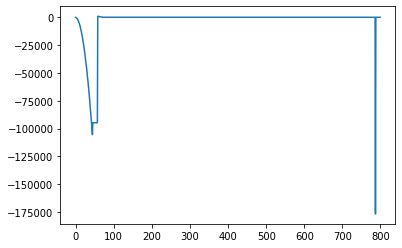

In [780]:
import matplotlib.pyplot as plt
plt.plot(list)

In [781]:
team = f.get_particle_team()

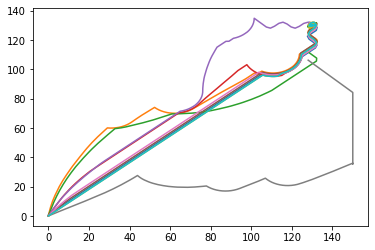

In [782]:
trajectory = []
for t in team:
    trajectory.append(t.get_trajectory())
    plt.plot(trajectory[-1][:, 0], trajectory[-1][:, 1])

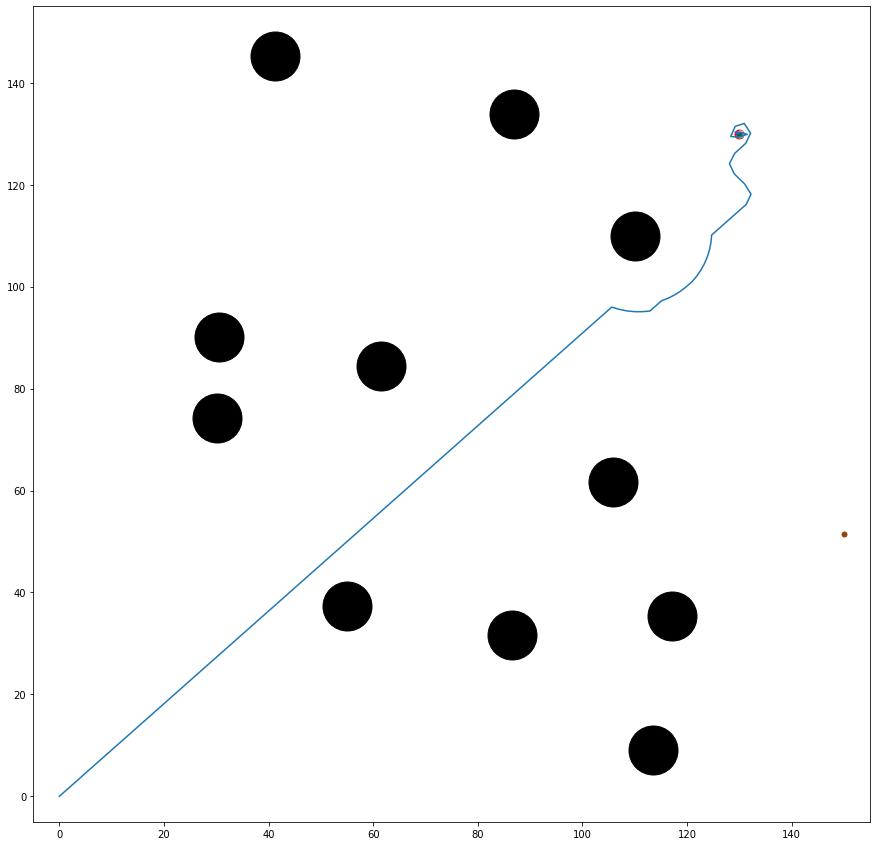

In [783]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(15,15))
#初始化窗口和坐标轴
# x1data, y1data = [], []
# x2data, y2data = [], []
# x3data, y3data = [], []

ax.scatter(destination[0], destination[1], c='r', s=80)
for i in range(hurdle_num):
    ax.scatter(hurdle[i][0], hurdle[i][1], c='k', s=2400)

#初始化x,y列表

ln = []
color = ['#008B8B','#A9A9A9','#F0068C','#0FA07A','#F000E6','#FAFAD2','#DA70D6','#8B4513','#D2B48C','#006347']
for i in range(10):
    ln.append(ax.plot(trajectory[i][0][0], trajectory[i][0][1], color[i], marker='o', markersize =5)[0])

#初始化绘制曲线的参数。
#init()函数初始化x,y轴范围
def init():
    ax.set_xlim(-5,155)
    ax.set_ylim(-5,155)
    return ln,
#迭代器，根据传入的frame更新x,y值
def update(iter):
    for i in range(10):
        x = trajectory[i][iter][0]
        y = trajectory[i][iter][1]
        ln[i].set_data(x, y)
    return ln
# interval：帧持续时间(milliseconds)
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, 200), init_func=init,  interval=100)
anim.save('tmp.gif', writer='pillow')
plt.plot(fast_trajectory[:, 0], fast_trajectory[:, 1])
plt.show()

In [329]:
plt.figure()
plt.scatter()

0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
